# Newbie task 2024

This Jupyter notebook presents two tasks for you to finish them. The tasks are designed in a way that they are not hard to complete and show some basic concepts of our codebase. If you run into any problems, please do not hesitate to ask us for support!

**Install pytorch before solving tasks**

**!Submit your solutions as a part of this Jupyter Notebook!**

## Vision and cone detection

<!-- ![](vision/image.jpg) -->
<!-- <div> -->
<img src="vision/image_1.jpg" width="500"/>
<!-- </div> -->

In order for the car to drive throught a race track, it first needs to be able to see it. For that purpose, the car is equiped with a single RGB camera, output of which you can see below. After our vision system receives an image from the camera, it runs it throught a neural network, which detects each traffic cone in the image as a colored bounding box surrouding it. Finally, we would like to know the position of each cone in 3D, not just in the image. We achieve this, by projecting image position of each cone into the 2D world coordinates, using what is a called a homography projection, while assuming that the z-coordinate is 0. Giving us the 3D position of the cone.

### Task

Your task will be: given the **image from the camera**, the **output of the neural network** and the **homography matrix H**, realising the image->world projection, do following two tasks:
1. **draw the output of the neural network into the image** (draw the bounding boxes around detected cones)
2. **compute and draw a local map of the track in front of the formula by projecting the bboxes using the H matrix**

You can find all the files you need in **vision/** folder. Namely:
- files:
    - **image.jpg** - camera image
    - **bboxes.npy** - NN output, aka bounding boxes, for the given image
        - bboxes is a **Nx6** matrix, where each row corresponds to a single bounding box detection
        - each row is coded in the following way - [**top_left_x**, **top_left_y**, **bot_right_x**, **bot_right_y**, **confidence**(you can ignore this), **cone_class(color)**]
    - **H.npy** - homography matrix mapping between the image and the ground plane
    - hints: **.npy** files are simply for storing numpy matrices in files, use numpy to load them
    
    
#### 1. visualizing the image and the bboxes
I would recommend to first load the image and the **bbox.npy** data, try plotting the image and print the bounding boxes. Subsequently try drawing the bounding boxes into the image. I would recommend either using matplotlib or opencv library for plotting / image manipulation. The result should look similar to the following image (except for the path visualization).

<!-- ![](https://i.imgur.com/qmztvrT.png) -->
<img src="assets/car_vision.png" width="800"/>



#### 2. projecting the points into 3D coordinates
The homography matrix gives us a way, to map every point in the image onto a corresponding coordinate on the ground plane in world. You don't need to concern yourself about how this mapping works, only how to apply it.
The homography matrix is described by the following equation:
<!-- ![](https://miro.medium.com/max/978/1*6rzcWyE2qBzmlXewkP2qdA.png) -->
<img src="https://miro.medium.com/max/978/1*6rzcWyE2qBzmlXewkP2qdA.png" width="300"/>

Basically, you have your image point **(x,y)**, you turn it into a **(x,y,1)** vector (so-called homogenous coordinates), which you multiply by the 3x3 H matrix. The result will be the position of the point in the world, but multiplied by some scalar, so you need to divide the result by its 3rd coordinate, so you get **(x', y', 1)**. 

Of course you might be thinking, that the bounding box of a cone is represented by two image points and that's true. The image point you need to multiply by H is actually **the center point of the bottom line** of each bounding box. After you project each bounding box by the **H** matrix and plot it, the result should look similar to the following image, where the black dot is the car, yellow / blue / orange / red points correspond to the cones projected into the world.

<img src="assets/detections.png" width="800"/>

You are given 20 images and 20 corresponding .npy files storing the corresponding bounding box matrices. Visualize the bounding boxes and the local maps with projected cone positions. Try to plot them all in one matplotlib figure (you can use subplotting). As a bonus, you can try to implement it in such a way that you project all detections just once (a single numpy matrix multiplication).

 If you have any questions, just ask. 

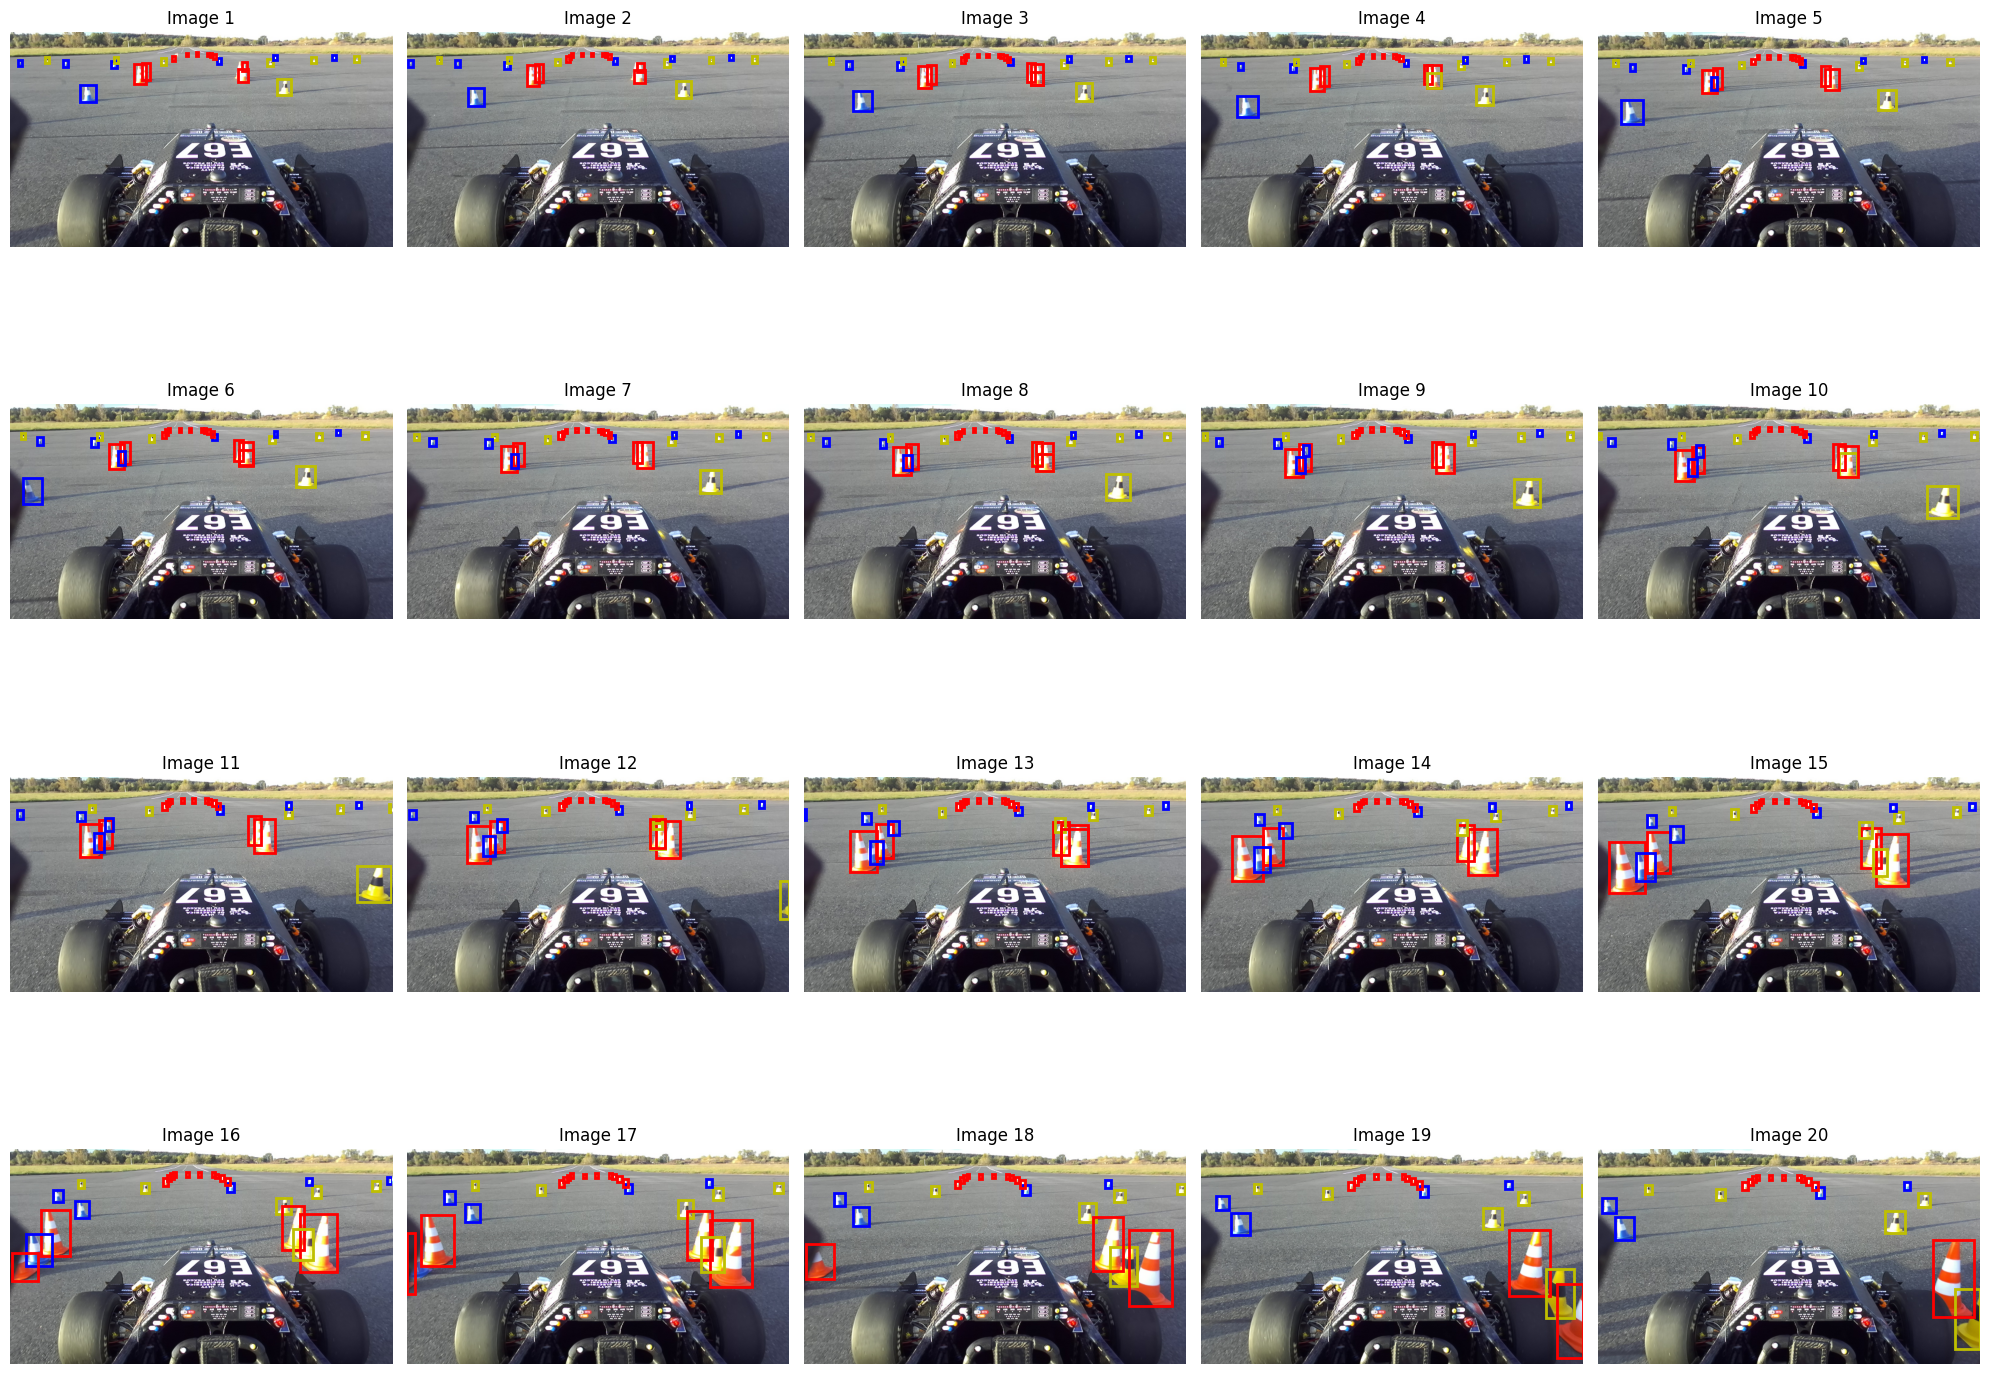

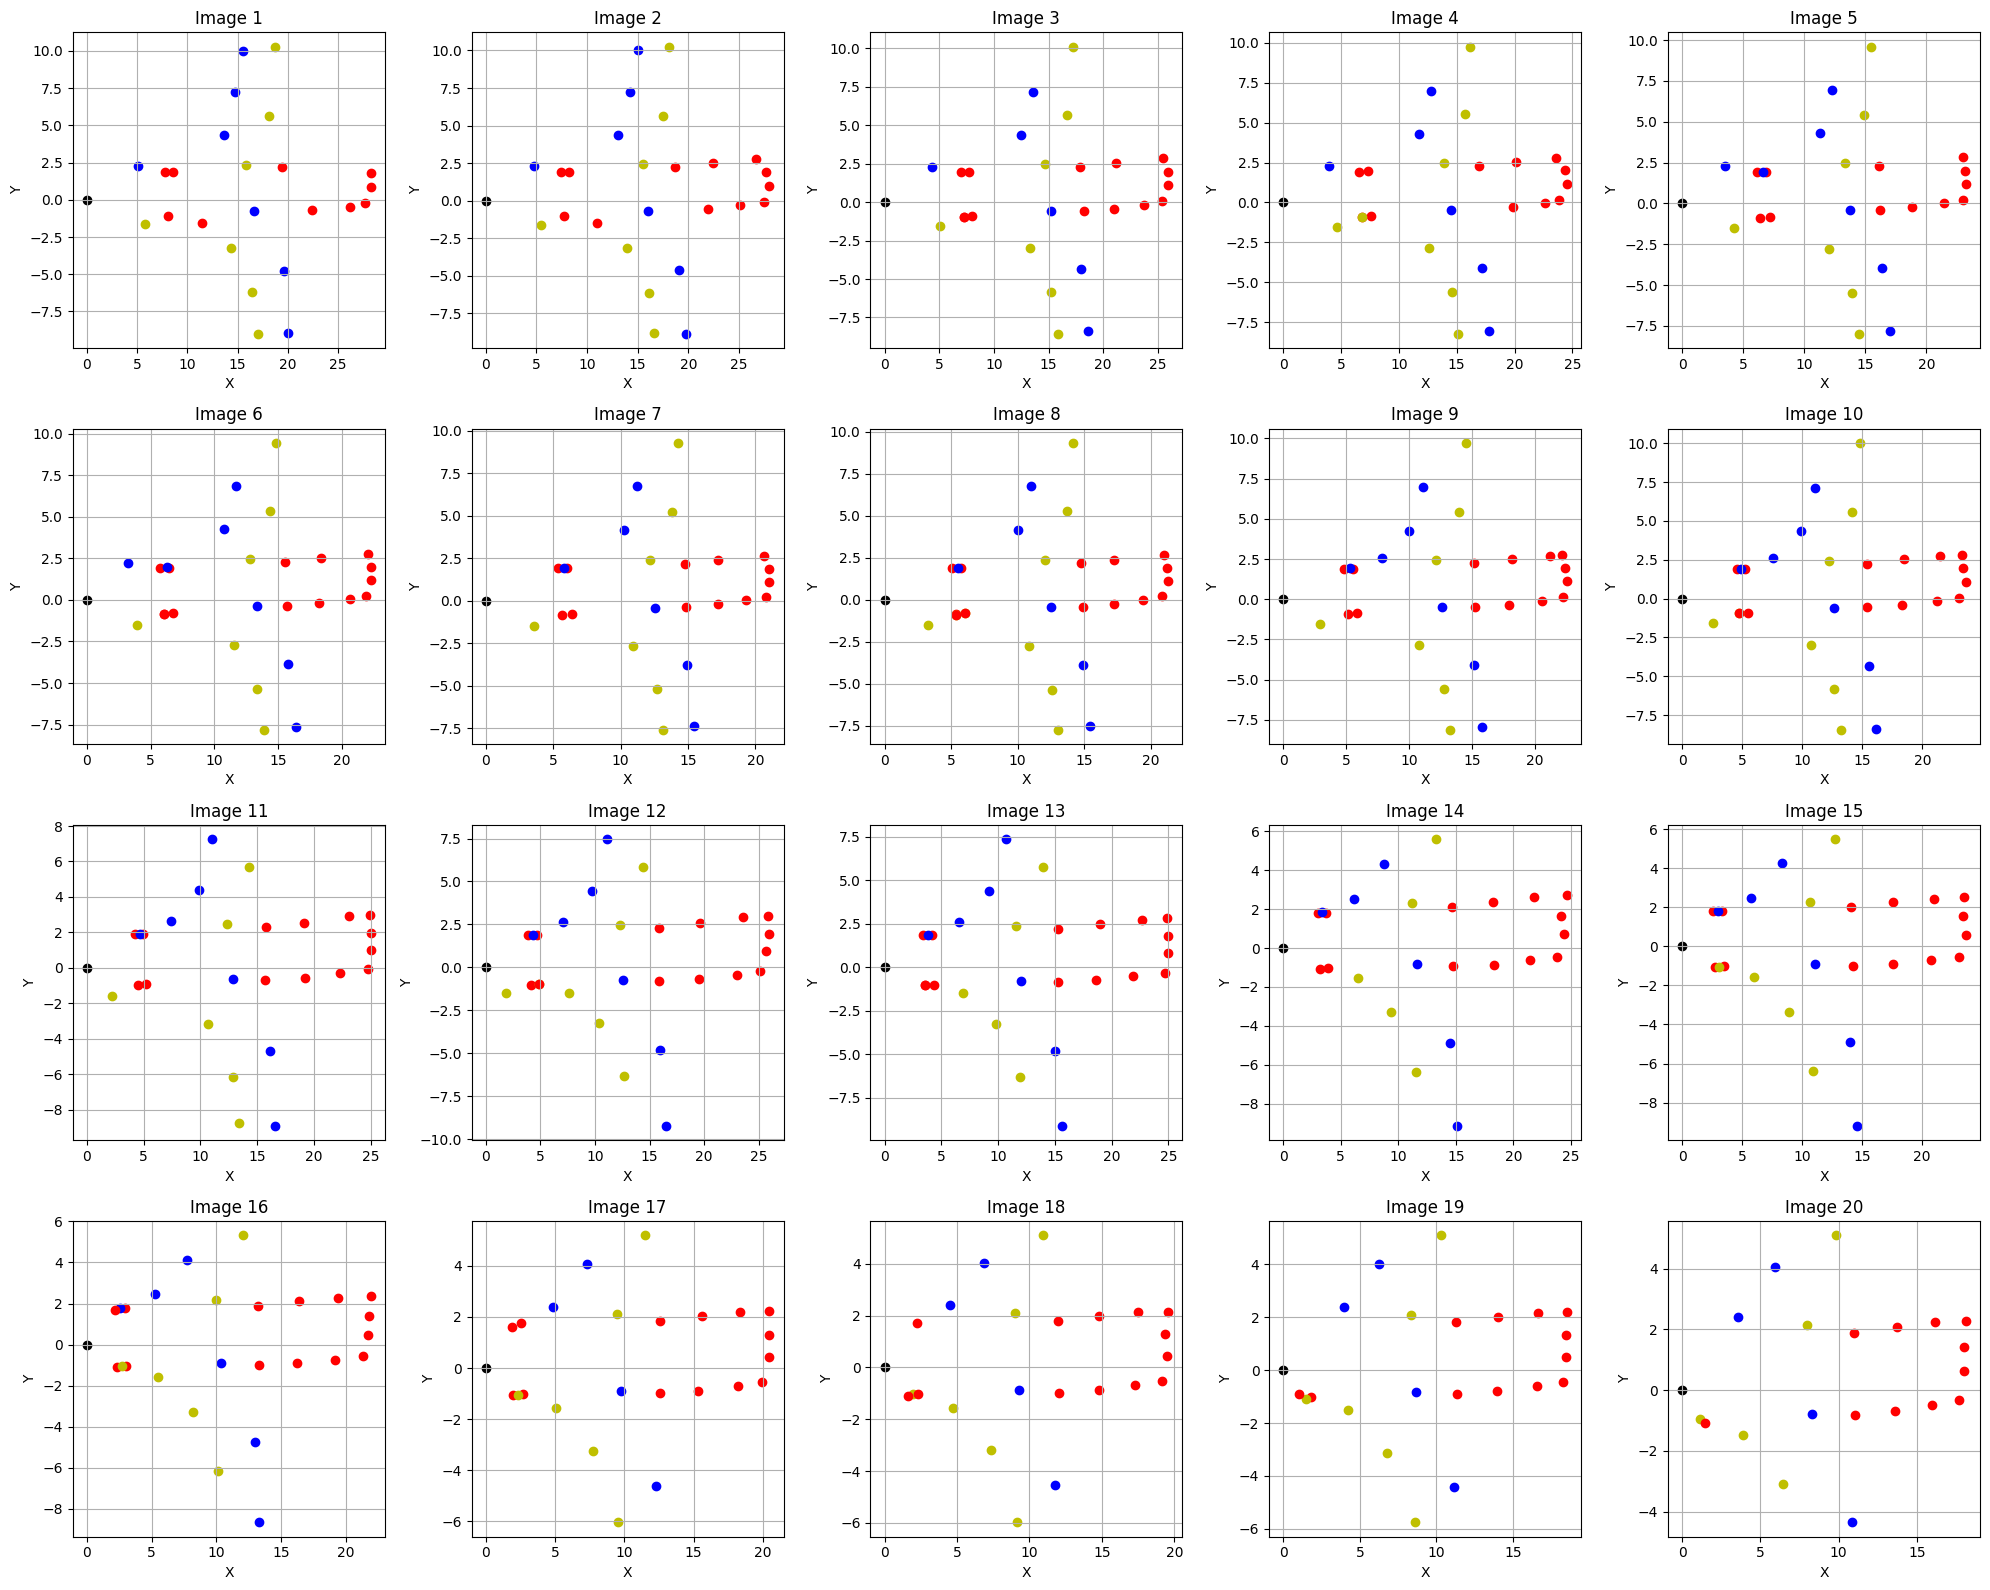

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image

# Function to draw bounding boxes on an image
def draw_bboxes(image, bboxes):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    # Draw each bounding box with color based on its class
    for bbox in bboxes:
        top_left = (bbox[0], bbox[1])
        width = bbox[2] - bbox[0]
        height = bbox[3] - bbox[1]
        
        # Assign color based on class (0 = yellow, 1 = blue, others = red)
        color = 'y' if bbox[5] == 0 else 'b' if bbox[5] == 1 else 'r'
        
        # Draw the rectangle
        rect = plt.Rectangle(top_left, width, height, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
    
    return ax

# Function to project bounding box points using the homography matrix
def project_points(bboxes, H):
    # Calculate the bottom center of each bounding box
    centers_bottom = np.array([[(bbox[0] + bbox[2]) / 2, bbox[3], 1.0] for bbox in bboxes])
    
    # Convert points and homography matrix to torch tensors
    centers_bottom = torch.tensor(centers_bottom.T, dtype=torch.float32)
    H_torch = torch.tensor(H, dtype=torch.float32)
    
    # Apply homography matrix to project the points
    projected_points = torch.matmul(H_torch, centers_bottom)
    projected_points = projected_points / projected_points[2, :]  # Normalize by the homogeneous coordinate
    
    # Collect the projected points along with their class
    points = [(projected_points[0, i].item(), projected_points[1, i].item(), bboxes[i, 5]) for i in range(projected_points.shape[1])]
    return points

# Load the homography matrix
H = np.load('vision/homography_matrix.npy')

# Load images and bounding boxes
all_bboxes = []
all_images = []

for i in range(20):
    image = Image.open(f'vision/image_{i+1}.jpg')
    bboxes = np.load(f'vision/bboxes_{i+1}.npy')
    all_bboxes.append(bboxes)
    all_images.append(np.array(image))

# Plot original images with bounding boxes
fig, axs = plt.subplots(4, 5, figsize=(20, 16))
axs = axs.flatten()

for i in range(20):
    ax = axs[i]
    ax.imshow(all_images[i])
    
    # Draw bounding boxes on each image
    for bbox in all_bboxes[i]:
        color = 'y' if bbox[5] == 0 else 'b' if bbox[5] == 1 else 'r'
        top_left = (bbox[0], bbox[1])
        width = bbox[2] - bbox[0]
        height = bbox[3] - bbox[1]
        rect = plt.Rectangle(top_left, width, height, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
    
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Plot the projected points for each image
fig, axs = plt.subplots(4, 5, figsize=(20, 16))
axs = axs.flatten()

for i in range(20):
    ax = axs[i]
    
    # Project the points using the homography matrix
    projected_points = project_points(all_bboxes[i], H)
    
    # Scatter plot of projected points
    for point in projected_points:
        color = 'y' if point[2] == 0 else 'b' if point[2] == 1 else 'r'
        ax.scatter(point[0], point[1], c=color)
    
    # Plot the origin (0, 0) for reference
    ax.scatter(0, 0, c='k')
    
    ax.set_title(f'Image {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True)

plt.tight_layout()
plt.show()


## Reading Logs

This second task is designed to help you to understand the logging infrastructure of our system.

### LogReader example

Each message has this form (timestamp, (NAME, data_dictionary)

Data dictionary have those keys:
- mission_id - id of mission (Int)
- ASM - Autonomous state machine state (Int)
- car_status - The status of the whole car (Int)
- finished - If the car has finished the run (Bool)
- steering_angle_setpoint - Requested angle of steering wheel by autonomous system (Float)
- steering_angle - Actual angle of steering wheel (Float)
- speed_setpoint - Requested speed by autonomous system (Float)
- mission_log - Log of the mission (Dictionary)
- mission_kwargs - Arguments for the mission (Dictionary)
- mission_kwargs keys:
    - ins_position - Position from global navigation system (Tuple, x,y)
    - ins_velocity - Velocity from global navigation system (Tuple, x,y,z)


In [67]:
from helpers import LogReader
i = 0
for msg in LogReader('mission_17_10_2023-16_29_06.pkl'):
    i+= 1
    if i > 1000:
        print(msg)
        break

(4625.122704704, ('FRAME', {'mission_log': {'debug': {'time_since_start': 26.41531512199981, 'lap_time': 26.41531512199981, 'finish_time': inf, 'laps_driven': '0 / 100', 'lookahead_dist': 5.5, 'linear_gain': 1.8}, 'path': array([[ 0.        ,  0.        ],
       [ 0.74227275, -0.38631881],
       [ 1.34893739, -0.55754573],
       [ 1.85456653, -0.56184563],
       [ 2.28576658, -0.43686869],
       [ 2.66273105, -0.21187568],
       [ 3.00053904,  0.09041065],
       [ 3.31022752,  0.45222112],
       [ 3.59966599,  0.8594154 ],
       [ 3.87426182,  1.3004101 ],
       [ 4.13752495,  1.76535251],
       [ 4.39152048,  2.24553285],
       [ 4.63723754,  2.73302814],
       [ 4.87490301,  3.22057042],
       [ 5.10426869,  3.70163242],
       [ 5.32490029,  4.17072347],
       [ 5.53649684,  4.62388863],
       [ 5.73926906,  5.05940402],
       [ 5.93440507,  5.47866117],
       [ 6.12465215,  5.8872334 ]]), 'speedprofile_log': None, 'controller_log': {'linear': 43.78795214490817, 'n

### Task

We have provided you with log file from our SIL (Software in the loop) testing.

The log contains 100 laps on our simulated test track, your task is to find the fastest and slowest lap from those 100.

You should provide us with the lap time and the lap number.

For the slowest and fastest lap you should also provide is with plotted graph of the lap.

The graph should contain the following information:
- Speed (visualized as color of the line, heat map in simmilar style as in the example below)
- Plot in global x,y coordinates such as in the example below

Good luck!

<img src="assets/example.png" style="height:300px" />


Fastest Lap: Lap 57 with time 14.744778569000118 seconds
Slowest Lap: Lap 19 with time 46.167488365999816 seconds


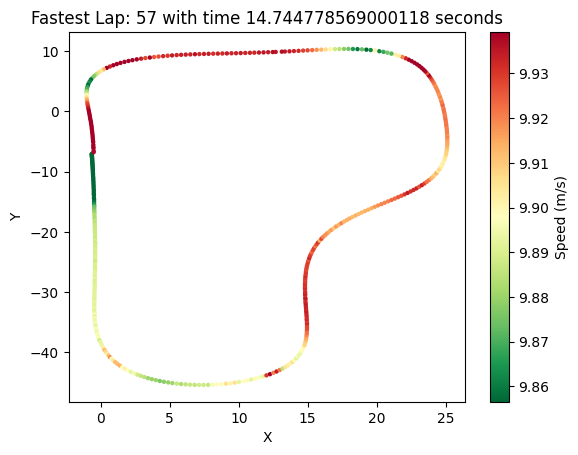

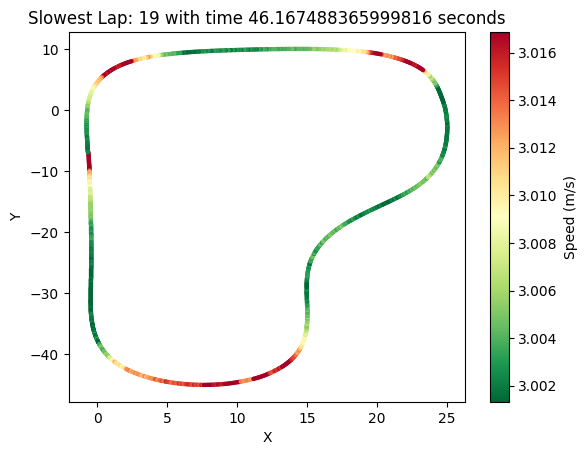

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from helpers import LogReader
from matplotlib import colors

# Extract lap data from the log, organizing by lap number
def extract_lap_data(log_reader):
    laps = {}
    for timestamp, (name, data) in log_reader:
        # Ensure we have mission log data and debug information
        if 'mission_log' not in data or 'debug' not in data['mission_log']:
            continue
        debug_info = data['mission_log']['debug']
        
        # Only continue if laps_driven and lap_time data are available
        if 'laps_driven' not in debug_info or 'lap_time' not in debug_info:
            continue
        
        # Parse the lap number and time
        lap_number = int(debug_info['laps_driven'].split('/')[0].strip())
        lap_time = debug_info['lap_time']
        
        # Collect lap data based on lap number
        if lap_number not in laps:
            laps[lap_number] = []
        laps[lap_number].append((timestamp, data, lap_time))
    
    return laps

# Calculate lap times from the last log entry for each lap
def calculate_lap_times(laps):
    lap_times = {}
    for lap_number, lap in laps.items():
        lap_time = lap[-1][2]  # Take the lap time from the last entry
        lap_times[lap_number] = lap_time
    return lap_times

# Plot the lap on the track, with color-coded speeds
def plot_lap(lap, title):
    positions = [data['mission_kwargs']['ins_position'] for _, data, _ in lap]
    speeds = [data['mission_kwargs']['actual_speed'] for _, data, _ in lap]

    # Convert to numpy arrays for easier manipulation
    positions = np.array(positions)
    speeds = np.array(speeds)
    
    # Use percentiles to exclude extreme outliers
    lower_percentile = np.percentile(speeds, 8)
    upper_percentile = np.percentile(speeds, 92)

    # Normalize speeds for better color scaling
    norm = colors.Normalize(vmin=lower_percentile, vmax=upper_percentile)

    # Create the plot
    fig, ax = plt.subplots()
    sc = ax.scatter(positions[:, 0], positions[:, 1], c=speeds, cmap='RdYlGn_r', norm=norm, s=10, edgecolor='none')
    plt.colorbar(sc, label='Speed (m/s)')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.show()

# Load the log file and parse lap data
log_file_path = 'mission_17_10_2023-16_29_06.pkl'  # Adjust the file path as needed
log_reader = LogReader(log_file_path)

laps = extract_lap_data(log_reader)  # Extract laps from the log

# Calculate times for each lap
lap_times = calculate_lap_times(laps)

# Determine the fastest and slowest laps
fastest_lap_number = min(lap_times, key=lap_times.get)
slowest_lap_number = max(lap_times, key=lap_times.get)

fastest_lap_time = lap_times[fastest_lap_number]
slowest_lap_time = lap_times[slowest_lap_number]

# Print lap details
print(f"Fastest Lap: Lap {fastest_lap_number} with time {fastest_lap_time} seconds")
print(f"Slowest Lap: Lap {slowest_lap_number} with time {slowest_lap_time} seconds")

# Plot the fastest and slowest laps
plot_lap(laps[fastest_lap_number], f'Fastest Lap: {fastest_lap_number} with time {fastest_lap_time} seconds')
plot_lap(laps[slowest_lap_number], f'Slowest Lap: {slowest_lap_number} with time {slowest_lap_time} seconds')